In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [2]:

import sys
from PIL import Image
sys.modules['Image'] = Image

In [3]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [5]:
# 資料路徑
DATASET_PATH  = 'kaggle_dogcat'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                  validation_split=0.3)
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                 subset='training')
valid_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset='validation')


# valid_datagen = ImageDataGenerator()
# valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='categorical',
#                                                   shuffle=False,
#                                                   batch_size=BATCH_SIZE)

Found 2800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [6]:
train_batches.next()[0].shape

(8, 224, 224, 3)

In [7]:
train_batches.next()[1].shape

(8, 2)

In [8]:
valid_batches.next()[0].shape

(8, 224, 224, 3)

In [9]:
valid_batches.next()[1].shape

(8, 2)

In [10]:
img_combine(valid_batches.next()[0].astype("int"))

<Figure size 800x100 with 8 Axes>

In [11]:
train_batches.next()[1]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

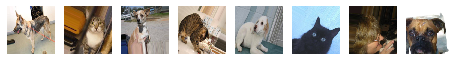

In [12]:
img_combine(train_batches.next()[0].astype("int"))

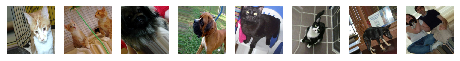

In [13]:
img_combine(train_batches.next()[0].astype("int"))

In [14]:
train_batches.samples // BATCH_SIZE

350

In [15]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

/home/yun/.conda/envs/tf_keras/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0

Epoch 1/20
350/350 [==============================] - 55s 158ms/step - loss: 0.8808 - acc: 0.7296 - val_loss: 0.2835 - val_acc: 0.8925
Epoch 2/20
350/350 [==============================] - 41s 118ms/step - loss: 0.4859 - acc: 0.8632 - val_loss: 0.1834 - val_acc: 0.9358
Epoch 3/20
350/350 [==============================] - 41s 116ms/step - loss: 0.3838 - acc: 0.8961 - val_loss: 0.2032 - val_acc: 0.9392
Epoch 4/20
350/350 [==============================] - 41s 117ms/step - loss: 0.2979 - acc: 0.9146 - val_loss: 0.1446 - val_acc: 0.9525
Epoch 5/20
350/350 [==============================] - 41s 118ms/step - loss: 0.3161 - acc: 0.9189 - val_loss: 0.1421 - val_acc: 0.9533
Epoch 6/20
350/350 [==============================] - 41s 117ms/step - loss: 0.2617 - acc: 0.9314 - val_loss: 0.1198 - val_acc: 0.9692
Epoch 7/20
350/350 [==============================] - 40s 116ms/step - loss: 0.2181 - acc: 0.9368 - val_loss: 0.1392 - val_acc: 0.9600
Epoch 8/20
350/350 [==============================] - 4

In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np

In [4]:
# 從參數讀取圖檔路徑
DATASET_PATH  = 'kaggle_dogcat'
files = DATASET_PATH + '/valid'
cls_list = ['cats', 'dogs']
net = load_model('model-resnet50-final.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
imgname_list =[]
prob = []
DATASET_PATH  = 'kaggle_dogcat'
for i in range(0,400):
    print("%03d" % i)
    imgname_list.append(i)
    imgname=("%03d" % i)
    f = DATASET_PATH + '/valid/'+imgname+'.jpg'
    img = image.load_img(f, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net.predict(x)[0]
    prob.append(pred[0])
    print('pred',pred)
    top_inds = pred.argsort()[::-1][:5]
    print(f)
    for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

000
pred [1.000000e+00 5.742079e-12]
kaggle_dogcat/valid/000.jpg
    1.000  cats
    0.000  dogs
001
pred [1.8005733e-06 9.9999821e-01]
kaggle_dogcat/valid/001.jpg
    1.000  dogs
    0.000  cats
002
pred [9.999994e-01 6.467856e-07]
kaggle_dogcat/valid/002.jpg
    1.000  cats
    0.000  dogs
003
pred [9.695771e-16 1.000000e+00]
kaggle_dogcat/valid/003.jpg
    1.000  dogs
    0.000  cats
004
pred [9.9999988e-01 1.1603302e-07]
kaggle_dogcat/valid/004.jpg
    1.000  cats
    0.000  dogs
005
pred [1.0000000e+00 3.4052195e-11]
kaggle_dogcat/valid/005.jpg
    1.000  cats
    0.000  dogs
006
pred [5.885008e-07 9.999994e-01]
kaggle_dogcat/valid/006.jpg
    1.000  dogs
    0.000  cats
007
pred [1.0000000e+00 4.6710005e-13]
kaggle_dogcat/valid/007.jpg
    1.000  cats
    0.000  dogs
008
pred [9.9987364e-01 1.2635608e-04]
kaggle_dogcat/valid/008.jpg
    1.000  cats
    0.000  dogs
009
pred [9.9992704e-01 7.2995164e-05]
kaggle_dogcat/valid/009.jpg
    1.000  cats
    0.000  dogs
010
pred [7.516612

pred [4.879938e-15 1.000000e+00]
kaggle_dogcat/valid/084.jpg
    1.000  dogs
    0.000  cats
085
pred [2.7227003e-13 1.0000000e+00]
kaggle_dogcat/valid/085.jpg
    1.000  dogs
    0.000  cats
086
pred [9.9999893e-01 1.1317225e-06]
kaggle_dogcat/valid/086.jpg
    1.000  cats
    0.000  dogs
087
pred [9.9999988e-01 1.1996055e-07]
kaggle_dogcat/valid/087.jpg
    1.000  cats
    0.000  dogs
088
pred [9.9912781e-01 8.7222166e-04]
kaggle_dogcat/valid/088.jpg
    0.999  cats
    0.001  dogs
089
pred [2.8359246e-11 1.0000000e+00]
kaggle_dogcat/valid/089.jpg
    1.000  dogs
    0.000  cats
090
pred [1.000000e+00 4.527369e-12]
kaggle_dogcat/valid/090.jpg
    1.000  cats
    0.000  dogs
091
pred [1.0887836e-13 1.0000000e+00]
kaggle_dogcat/valid/091.jpg
    1.000  dogs
    0.000  cats
092
pred [3.4321088e-12 1.0000000e+00]
kaggle_dogcat/valid/092.jpg
    1.000  dogs
    0.000  cats
093
pred [7.314029e-14 1.000000e+00]
kaggle_dogcat/valid/093.jpg
    1.000  dogs
    0.000  cats
094
pred [9.9999309e

pred [5.394841e-09 1.000000e+00]
kaggle_dogcat/valid/173.jpg
    1.000  dogs
    0.000  cats
174
pred [2.8671916e-08 1.0000000e+00]
kaggle_dogcat/valid/174.jpg
    1.000  dogs
    0.000  cats
175
pred [0.92742014 0.07257986]
kaggle_dogcat/valid/175.jpg
    0.927  cats
    0.073  dogs
176
pred [3.1524134e-08 1.0000000e+00]
kaggle_dogcat/valid/176.jpg
    1.000  dogs
    0.000  cats
177
pred [2.4760842e-09 1.0000000e+00]
kaggle_dogcat/valid/177.jpg
    1.000  dogs
    0.000  cats
178
pred [1.0000000e+00 4.3755693e-14]
kaggle_dogcat/valid/178.jpg
    1.000  cats
    0.000  dogs
179
pred [0.0012958 0.9987042]
kaggle_dogcat/valid/179.jpg
    0.999  dogs
    0.001  cats
180
pred [1.0000000e+00 1.6278592e-09]
kaggle_dogcat/valid/180.jpg
    1.000  cats
    0.000  dogs
181
pred [1.0000000e+00 4.4378106e-09]
kaggle_dogcat/valid/181.jpg
    1.000  cats
    0.000  dogs
182
pred [3.2026215e-10 1.0000000e+00]
kaggle_dogcat/valid/182.jpg
    1.000  dogs
    0.000  cats
183
pred [8.453413e-09 1.00000

pred [1.000000e+00 8.807384e-15]
kaggle_dogcat/valid/260.jpg
    1.000  cats
    0.000  dogs
261
pred [1.0000000e+00 3.0266753e-13]
kaggle_dogcat/valid/261.jpg
    1.000  cats
    0.000  dogs
262
pred [1.0000000e+00 2.6889545e-12]
kaggle_dogcat/valid/262.jpg
    1.000  cats
    0.000  dogs
263
pred [4.251198e-15 1.000000e+00]
kaggle_dogcat/valid/263.jpg
    1.000  dogs
    0.000  cats
264
pred [3.8081143e-06 9.9999619e-01]
kaggle_dogcat/valid/264.jpg
    1.000  dogs
    0.000  cats
265
pred [5.3650137e-08 1.0000000e+00]
kaggle_dogcat/valid/265.jpg
    1.000  dogs
    0.000  cats
266
pred [1.250711e-09 1.000000e+00]
kaggle_dogcat/valid/266.jpg
    1.000  dogs
    0.000  cats
267
pred [2.5577371e-08 1.0000000e+00]
kaggle_dogcat/valid/267.jpg
    1.000  dogs
    0.000  cats
268
pred [1.0000000e+00 2.2386007e-15]
kaggle_dogcat/valid/268.jpg
    1.000  cats
    0.000  dogs
269
pred [9.9466655e-15 1.0000000e+00]
kaggle_dogcat/valid/269.jpg
    1.000  dogs
    0.000  cats
270
pred [1.0000000e

pred [1.9003821e-16 1.0000000e+00]
kaggle_dogcat/valid/346.jpg
    1.000  dogs
    0.000  cats
347
pred [5.0544484e-17 1.0000000e+00]
kaggle_dogcat/valid/347.jpg
    1.000  dogs
    0.000  cats
348
pred [1.0000000e+00 2.3187578e-12]
kaggle_dogcat/valid/348.jpg
    1.000  cats
    0.000  dogs
349
pred [1.000000e+00 4.002164e-11]
kaggle_dogcat/valid/349.jpg
    1.000  cats
    0.000  dogs
350
pred [5.8373204e-09 1.0000000e+00]
kaggle_dogcat/valid/350.jpg
    1.000  dogs
    0.000  cats
351
pred [1.0000000e+00 1.4663019e-08]
kaggle_dogcat/valid/351.jpg
    1.000  cats
    0.000  dogs
352
pred [2.8090186e-11 1.0000000e+00]
kaggle_dogcat/valid/352.jpg
    1.000  dogs
    0.000  cats
353
pred [1.0000000e+00 4.2232513e-11]
kaggle_dogcat/valid/353.jpg
    1.000  cats
    0.000  dogs
354
pred [2.030225e-12 1.000000e+00]
kaggle_dogcat/valid/354.jpg
    1.000  dogs
    0.000  cats
355
pred [1.000000e+00 9.002242e-11]
kaggle_dogcat/valid/355.jpg
    1.000  cats
    0.000  dogs
356
pred [1.0000000e

In [12]:
df = {"ID":imgname_list,"Predicted":prob}

In [13]:
import pandas as pd
df_final = pd.DataFrame(df)

In [14]:
df_final

,ID,Predicted
0,0,1.000000e+00
1,1,1.800573e-06
2,2,9.999994e-01
3,3,9.695771e-16
4,4,9.999999e-01
...,...,...
395,395,1.611960e-09
396,396,9.829642e-01
397,397,1.000000e+00
398,398,1.000000e+00


In [16]:
df_final.to_csv("predict.csv")